In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import time

# Generate Data

In [2]:
# DP parameters
x_dim = 2
k_approx = 5
num_obs = 12

# prior parameters
alpha = 1.0 # DP parameter
mu_prior = np.zeros(x_dim)
mu_prior_info = 1.0 * np.eye(x_dim)

info_x = 1.0 * np.eye(x_dim)

# true means
mu_spacing = np.linspace(-10, 10, k_approx)
true_mu = np.array([ mu_spacing, mu_spacing]).T

# draw beta sticks
true_v = np.zeros(k_approx)
true_pi = np.zeros(k_approx)
stick_remain = np.zeros(k_approx)

true_v[0] = np.random.beta(1, alpha)
true_pi[0] = true_v[0]
stick_remain[0] = 1 - true_v[0]

for i in range(1, k_approx): 
    if i == k_approx - 1: # the last stick
        true_v[i] = 1.0
    else: 
        true_v[i] = np.random.beta(1, alpha)
    
    true_pi[i] = stick_remain[i - 1] * true_v[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - true_v[i])
    

# draw group indicators
"""true_z = np.random.multinomial(1, true_pi, num_obs)
true_z_ind = np.full(num_obs, -1)
for row in np.argwhere(true_z):
    true_z_ind[row[0]] = row[1]
"""    

true_z_ind = np.random.choice(range(k_approx), p = true_pi, size = num_obs)
true_z = np.zeros((num_obs, k_approx))
for i in range(num_obs): 
    true_z[i, true_z_ind[i]] = 1.0

# draw observations
x = np.array([ np.random.multivariate_normal(
                true_mu[true_z_ind[n]], np.linalg.inv(info_x)) \
               for n in range(num_obs) ])

observed mixture proportions: 
 [ 0.58333333  0.41666667  0.          0.          0.        ]
true mixture proportions: 
 [ 0.49142064  0.42663463  0.07482192  0.0013834   0.00573942]


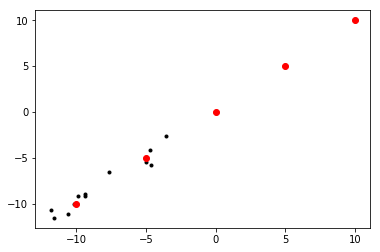

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_approx):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

## Set up VB model

In [4]:
import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector

In [5]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [6]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='mu_prior_mean', size=x_dim, val=mu_prior))
prior_params.push_param(PosDefMatrixParam(name='mu_prior_info', size=x_dim, val=mu_prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

## Initialize

In [7]:
## initialize VB params

true_init = True
if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    
    true_z_ = deepcopy(true_z)
    true_z_[true_z == 1] = 1 - 10**(-8)
    true_z_[true_z == 0] = 0 + 10**(-8)
    
    vb_params['global']['mu'].set(true_mu)
    vb_params['global']['v_sticks'].alpha.set(true_tau)
    vb_params['local']['e_z'].set(true_z_)

else: 
    init_tau = np.random.uniform(.1, 1, np.shape(vb_params['global']['v_sticks'].alpha.get()))
    init_mu = np.random.uniform(-10, 10, np.shape(vb_params['global']['mu'].get()))
    init_z = np.random.uniform(0.01, 0.99, np.shape(vb_params['local']['e_z'].get()))
    
    vb_params['global']['mu'].set(true_mu)
    vb_params['global']['v_sticks'].alpha.set(init_tau)
    vb_params['local']['e_z'].set(init_z)

init_par_vec = vb_params.get_free()
global_init_par_vec = vb_params['global'].get_free()
    
## initialize prior params
prior_params['mu_prior_mean'].set(np.zeros(x_dim))
prior_params['mu_prior_info'].set(mu_prior_info)
prior_params['alpha'].set(alpha)
prior_params['info_x'].set(info_x)

## Define elbo

In [8]:
vb_params['global']['info'].set_free(np.random.random(vb_params['global']['info'].free_size()))

mu_info = vb_params['global']['info'].get()

print(np.linalg.slogdet(mu_info[2])[1])
np.linalg.slogdet(mu_info)[1]

2.17115877916


array([ 1.85308526,  0.77636869,  2.17115878,  1.18724932,  3.32939523])

In [9]:
# define entropies
def mu_entropy(mu_info):
    return 0.5 * np.sum(np.linalg.slogdet(mu_info)[1])

def beta_entropy(tau): 
    digamma_tau0 = sp.special.digamma(tau[:, 0])
    digamma_tau1 = sp.special.digamma(tau[:, 1])
    digamma_tausum = sp.special.digamma(np.sum(tau, 1))

    lgamma_tau0 = sp.special.gammaln(tau[:, 0])
    lgamma_tau1 = sp.special.gammaln(tau[:, 1])
    lgamma_tausum = sp.special.gammaln(np.sum(tau, 1))

    lbeta = lgamma_tau0 + lgamma_tau1 - lgamma_tausum

    return np.sum(
        lbeta - \
        (tau[:, 0] - 1.) * digamma_tau0 - \
        (tau[:, 1] - 1.) * digamma_tau1 + \
        (tau[:, 0] + tau[:, 1] - 2) * digamma_tausum)

def multinom_entropy(e_z): 
    return -1 * np.sum(e_z * np.log(e_z))


In [10]:
# define priors
def dp_prior(alpha, e_log_1mv):
    return (alpha - 1) * np.sum(e_log_1mv)
    
def normal_prior(mu, info, prior_mu, prior_info): 
    mu_centered = mu - prior_mu
    return - 0.5 * np.sum(np.einsum('ki, ij, kj -> k', mu_centered, prior_info, mu_centered)  + \
                          np.array([np.dot(np.diag(info[k]), np.diag(prior_info)) for k in range(k_approx)]))
                          # np.einsum('kii, ii -> k', info, prior_info)) # autograd doesn't like this last term?

    #return np.sum(np.expand_dims(np.einsum('ki, ij, kj -> k', mu_centered, prior_info, mu_centered), axis=0) + \
    #                  np.einsum('kii, ii -> k', info, prior_info)) # double check this at some point ...

In [11]:
mu = vb_params['global']['mu'].get()
info = vb_params['global']['info'].get()
tau = vb_params['global']['v_sticks'].alpha.get()

prior_mu = prior_params['mu_prior_mean'].get()
prior_info = prior_params['mu_prior_info'].get()
info_x = prior_params['info_x'].get()

print(np.einsum('ni, ij, kj -> nk', x, info_x, mu) )
print(np.dot(np.dot(x, info_x), mu.T))

[[ 190.34603576   95.17301788    0.          -95.17301788 -190.34603576]
 [ 104.58992894   52.29496447    0.          -52.29496447 -104.58992894]
 [ 217.75763691  108.87881846    0.         -108.87881846 -217.75763691]
 [ 185.81214047   92.90607023    0.          -92.90607023 -185.81214047]
 [ 225.61715877  112.80857938    0.         -112.80857938 -225.61715877]
 [ 142.13139209   71.06569604    0.          -71.06569604 -142.13139209]
 [  62.43657429   31.21828715    0.          -31.21828715  -62.43657429]
 [ 202.33715318  101.16857659    0.         -101.16857659 -202.33715318]
 [ 231.65880635  115.82940317    0.         -115.82940317 -231.65880635]
 [ 183.35998985   91.67999493    0.          -91.67999493 -183.35998985]
 [ 104.61114086   52.30557043    0.          -52.30557043 -104.61114086]
 [  88.72918471   44.36459236    0.          -44.36459236  -88.72918471]]
[[ 190.34603576   95.17301788    0.          -95.17301788 -190.34603576]
 [ 104.58992894   52.29496447    0.          -52.2

In [12]:
def loglik_sticks_by_k(e_log_v, e_log_1mv): 
    k_approx = np.shape(e_log_v)[0] + 1
    e_log_stick_remain = np.array([np.sum(e_log_1mv[0:k]) for k in range(k_approx)])
    e_log_new_stick = np.concatenate((e_log_v, np.array([0]))) 
    
    return e_log_stick_remain + e_log_new_stick
    # return np.sum(np.dot(e_z, e_log_stick_remain + e_log_new_stick))
    
def loglik_obs_by_nk(mu, info, x, info_x):
    return np.einsum('ni, ij, kj -> nk', x, info_x, mu) + \
            - 0.5 * np.einsum('ki, ij, kj -> k', mu, info_x, mu) + \
            - 0.5 * np.array([np.dot(np.diag(info[k]), np.diag(info_x)) for k in range(k_approx)])
        
            # - 0.5 * np.einsum('kii, ii -> k', info, info_x) # autograd doesn't like this

def compute_elbo(x, vb_params, prior_params): 
    e_log_v = vb_params['global']['v_sticks'].e_log()[:,0] # E[log v]
    e_log_1mv = vb_params['global']['v_sticks'].e_log()[:,1] # E[log 1 - v]
    e_z = vb_params['local']['e_z'].get()
    mu = vb_params['global']['mu'].get()
    info = vb_params['global']['info'].get()
    tau = vb_params['global']['v_sticks'].alpha.get()
    
    prior_mu = prior_params['mu_prior_mean'].get()
    prior_info = prior_params['mu_prior_info'].get()
    info_x = prior_params['info_x'].get()
    
    prior = dp_prior(alpha, e_log_1mv) + normal_prior(mu, info, prior_mu, prior_info)
    
    # log likelihood of stick breaking process
    log_lik_ind = np.sum(np.dot(e_z, loglik_sticks_by_k(e_log_v, e_log_1mv)))
    
    # log likelihood of data generating process
    log_lik_obs = np.sum(e_z * loglik_obs_by_nk(mu, info, x, info_x))
    
    # log likelihood 
    log_lik = log_lik_obs + log_lik_ind + prior
    
    # entropy terms
    entropy = mu_entropy(info) + beta_entropy(tau) + multinom_entropy(e_z)
    
    return log_lik + entropy

In [13]:
e_log_v = vb_params['global']['v_sticks'].e_log()[:,0] # E[log v]
e_log_1mv = vb_params['global']['v_sticks'].e_log()[:,1] # E[log 1 - v]
e_z = vb_params['local']['e_z'].get()
mu = vb_params['global']['mu'].get()
info = vb_params['global']['info'].get()
tau = vb_params['global']['v_sticks'].alpha.get()

prior_mu = prior_params['mu_prior_mean'].get()
prior_info = prior_params['mu_prior_info'].get()
info_x = prior_params['info_x'].get()


np.shape(loglik_obs_by_nk(mu, info, x, info_x))

(12, 5)

In [14]:
def optimize_z(mu, info, x, info_x, e_log_v, e_log_1mv): 
    propto = np.exp(loglik_obs_by_nk(mu, info, x, info_x) + loglik_sticks_by_k(e_log_v, e_log_1mv))
    const = np.sum(propto, axis = 1)
    return propto / const[:, None]

In [15]:
compute_elbo(x, vb_params, prior_params)

558.12959614752617

In [16]:
class DP_normal_mixture(object):
    def __init__(self, x, vb_params, prior_params):
        self.x = x
        self.vb_params = deepcopy(vb_params)
        self.prior_params = deepcopy(prior_params)
        # self.weights = np.full((x.shape[0], 1), 1.0)
        # self.get_moment_jacobian = \
        #     autograd.jacobian(self.get_interesting_moments)

    def optimize_z(self):
        # Take a CAVI step on Z.
        mu = vb_params['global']['mu'].get()
        info = vb_params['global']['info'].get()
        
        info_x = prior_params['info_x'].get()
        e_log_v = vb_params['global']['v_sticks'].e_log()[:,0] # E[log v]
        e_log_1mv = vb_params['global']['v_sticks'].e_log()[:,1] # E[log 1 - v]
        
        e_z = optimize_z(mu, info, self.x, info_x, e_log_v, e_log_1mv)
        self.vb_params['local']['e_z'].set(e_z)

    def kl(self, verbose=False):
        self.optimize_z()
        elbo = compute_elbo(self.x, self.vb_params, self.prior_params)
        if verbose:
            print('ELBO:\t', elbo)
        return -1 * elbo
    
    
    #######################
    # TODO: Moments for sensitivity

    #def get_interesting_moments(self, global_free_params):
    #    self.params['global'].set_free(global_free_params)
    #    self.optimize_z()
    #    return self.params['global']['mu'].get_vector()



## Newton Optimization

In [17]:
from VariationalBayes.SparseObjectives import SparseObjective, Objective

model = DP_normal_mixture(x, vb_params, prior_params)
kl_obj = Objective(model.vb_params['global'], model.kl)

In [18]:
model.optimize_z()
model.kl(verbose = True)

ELBO:	 558.138048408


-558.13804840766409

In [19]:
def minimize_kl(kl_obj, init_x):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hess=kl_obj.fun_free_hessian,
        method='trust-ncg', options={'maxiter': 10, 'gtol': 1e-8})

    print('done')
    return vb_opt

vb_opt = minimize_kl(kl_obj, global_init_par_vec)
print(kl_obj.fun_free(vb_opt.x))

done
-730.188645128


In [20]:
model.vb_params['global'].set_free(vb_opt.x)

In [21]:
model.vb_params['global']['mu'].get()

array([[ -9.10473365e+00,  -8.79383101e+00],
       [ -4.25314920e+00,  -4.06284318e+00],
       [ -5.80798436e-05,  -4.26565903e-05],
       [ -3.93064023e-02,  -3.93064023e-02],
       [ -7.86128046e-02,  -7.86128046e-02]])

In [22]:
true_mu

array([[-10., -10.],
       [ -5.,  -5.],
       [  0.,   0.],
       [  5.,   5.],
       [ 10.,  10.]])